## 1 Functions and module

In [1]:
import pandas as pd
import gzip
import glob
import os
import subprocess

In [2]:
import subprocess

def get_fastq_read_count(fastq_gz_path):
    """
    Returns the total number of reads in a gzipped FASTQ file
    by counting lines (4 lines per read).
    """
    # Construct the shell command
    cmd = f"zcat {fastq_gz_path} | wc -l"
    
    # Execute the command and capture output
    line_count_str = subprocess.check_output(cmd, shell=True).decode().strip()
    line_count = int(line_count_str)
    
    # Each FASTQ read = 4 lines
    read_count = line_count // 4
    return read_count


## 2 Input and output address

In [3]:
parental_address = '/labs/mwinslow/Haiqing/UltraSeq_Projects/Cas12a_3guide_example'

In [4]:
raw_read_input_address = parental_address + '/01_data_collection/data/NGS_address'

In [5]:
summary_df_output_address  = parental_address + '/01_data_collection/data/reads_distribution_summary.csv'

In [6]:
fig_output_address  = parental_address + '/01_data_collection/fig/sorted_read_fractions_and_totals.pdf'

## 3 Get raw read counts

In [7]:
raw_read_input = pd.read_csv(raw_read_input_address,sep = '\t')

In [8]:
raw_read_input = pd.read_csv(raw_read_input_address, sep=',', header=None, names=['Address_r1', 'Address_r2', 'Sample_ID'])


In [9]:
raw_read_input.head()

,Address_r1,Address_r2,Sample_ID
0,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_18
1,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_14
2,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_19
3,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_13
4,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_07


In [10]:
# Take each file path from Address_r1.
# Run get_fastq_read_count(...) on it.
# Store the resulting integer in total_raw_reads.
raw_read_input['total_raw_reads'] = raw_read_input['Address_r1'].apply(get_fastq_read_count)


## 4 Get extracted read counts

In [11]:
# Lists to store counts of parsed reads and matched the flanking sequence pattern
reads_with_guides = []        
expected_reads_with_guides = [] # Subset of reads_with_guides that also have an expected gRNA

for sample_id in raw_read_input["Sample_ID"]:
    reads_with_guides_file = f"{parental_address}/01_data_collection/data/Bartender/{sample_id}/Intermediate_df.csv"
    expected_csv = f"{parental_address}/01_data_collection/data/Processed_data/{sample_id}/Combined_ND_df.csv"
    
    # Count lines (subtract 1 to account for header row)
    reads_with_guides_count = int(os.popen(f"wc -l < {reads_with_guides_file}").read().strip()) 
    cmd = f"awk -F, 'NR > 1 {{ sum += $NF }} END {{ print sum }}' {expected_csv}"
    expected_count = int(os.popen(cmd).read().strip())
    # Handle potential negative counts if file is empty
    reads_with_guides.append(max(reads_with_guides_count, 0))
    expected_reads_with_guides.append(max(expected_count, 0))



In [12]:
raw_read_input.head()

,Address_r1,Address_r2,Sample_ID,total_raw_reads
0,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_18,4390565
1,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_14,2272043
2,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_19,3605501
3,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_13,1549549
4,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_07,4181243


In [13]:
# Assign read counts to the DataFrame
raw_read_input['reads_with_guides'] = reads_with_guides
raw_read_input['expected_reads_with_guides'] = expected_reads_with_guides
raw_read_input['unexpected_reads_with_guides'] = raw_read_input['reads_with_guides'] - raw_read_input['expected_reads_with_guides']
# 'lowQ_reads' represent reads removed by adapter removal or those that cannot extract guides/barcodes
raw_read_input['lowQ_reads'] = (
    raw_read_input['total_raw_reads'] - raw_read_input['reads_with_guides'] 
)

# Calculate fractions for each category relative to total_raw_reads
raw_read_input['frac_unexpected'] = (
    raw_read_input['unexpected_reads_with_guides'] / raw_read_input['total_raw_reads']
)
raw_read_input['frac_expected'] = (
    raw_read_input['expected_reads_with_guides'] / raw_read_input['total_raw_reads']
)
raw_read_input['frac_lowQ_reads'] = (
    raw_read_input['lowQ_reads'] / raw_read_input['total_raw_reads']
)


In [14]:
raw_read_input.head()

,Address_r1,Address_r2,Sample_ID,total_raw_reads,reads_with_guides,expected_reads_with_guides,unexpected_reads_with_guides,lowQ_reads,frac_unexpected,frac_expected,frac_lowQ_reads
0,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_18,4390565,2883144,2756390,126754,1507421,0.028870,0.627798,0.343332
1,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_14,2272043,1258196,1205758,52438,1013847,0.023080,0.530693,0.446227
2,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_19,3605501,1619642,1506307,113335,1985859,0.031434,0.417780,0.550786
3,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_13,1549549,33353,21732,11621,1516196,0.007500,0.014025,0.978476
4,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,/labs/mwinslow/Haiqing/NGS_Raw_data/JH_HX_Cas1...,LA87_07,4181243,2407025,2285774,121251,1774218,0.028999,0.546673,0.424328


## 5 Plot

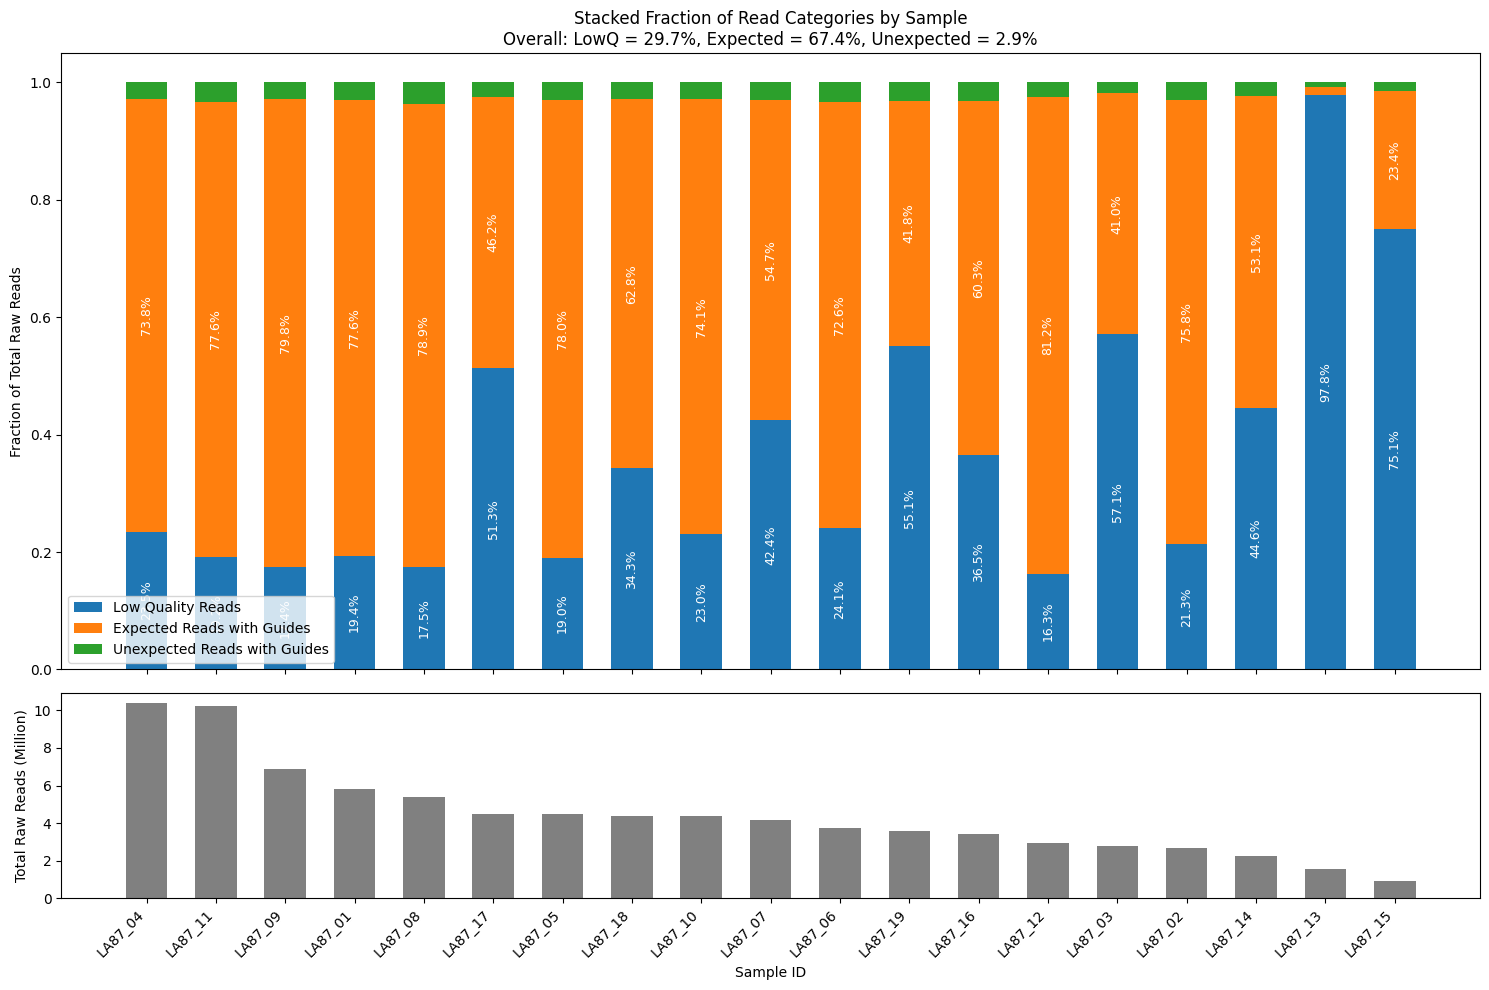

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Sort dataframe by total_raw_reads (descending)
raw_read_input_sorted = raw_read_input.sort_values(by='total_raw_reads', ascending=False).reset_index(drop=True)

# Compute overall fractions
overall_total = raw_read_input_sorted['total_raw_reads'].sum()
overall_lowq = raw_read_input_sorted['lowQ_reads'].sum()
overall_expected = raw_read_input_sorted['expected_reads_with_guides'].sum()
overall_unexpected = raw_read_input_sorted['unexpected_reads_with_guides'].sum()

overall_frac_lowq = overall_lowq / overall_total
overall_frac_expected = overall_expected / overall_total
overall_frac_unexpected = overall_unexpected / overall_total

# X positions
x = np.arange(len(raw_read_input_sorted))
bar_width = 0.6

# Fraction arrays
f_lowq = raw_read_input_sorted['frac_lowQ_reads'].values
f_expected = raw_read_input_sorted['frac_expected'].values
f_unexpected = raw_read_input_sorted['frac_unexpected'].values

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Upper panel: Stacked fraction plot
ax1.bar(x, f_lowq, width=bar_width, label='Low Quality Reads')
ax1.bar(x, f_expected, width=bar_width, bottom=f_lowq, label='Expected Reads with Guides')
ax1.bar(x, f_unexpected, width=bar_width, bottom=f_lowq + f_expected, label='Unexpected Reads with Guides')

# Annotate percentages with 90-degree rotation
for i in range(len(raw_read_input_sorted)):
    lowq_val = f_lowq[i]
    expected_val = f_expected[i]
    unexpected_val = f_unexpected[i]

    if lowq_val > 0.05:
        ax1.text(x[i], lowq_val / 2, f"{lowq_val:.1%}", ha='center', va='center', color='white', fontsize=9, rotation=90)
    if expected_val > 0.05:
        ax1.text(x[i], lowq_val + expected_val / 2, f"{expected_val:.1%}", ha='center', va='center', color='white', fontsize=9, rotation=90)
    if unexpected_val > 0.05:
        ax1.text(x[i], lowq_val + expected_val + unexpected_val / 2, f"{unexpected_val:.1%}", ha='center', va='center', color='white', fontsize=9, rotation=90)

ax1.set_ylabel('Fraction of Total Raw Reads')
ax1.set_title(
    f"Stacked Fraction of Read Categories by Sample\n"
    f"Overall: LowQ = {overall_frac_lowq:.1%}, Expected = {overall_frac_expected:.1%}, Unexpected = {overall_frac_unexpected:.1%}"
)
ax1.legend()

# Lower panel: Total reads bar plot
ax2.bar(x, raw_read_input_sorted['total_raw_reads'].values / 1e6, width=bar_width, color='gray')
ax2.set_ylabel('Total Raw Reads (Million)')
ax2.set_xlabel('Sample ID')

# Set x-axis labels
ax2.set_xticks(x)
ax2.set_xticklabels(raw_read_input_sorted['Sample_ID'], rotation=45, ha='right')

plt.tight_layout()

# Save figure if needed
plt.savefig(fig_output_address, format='pdf')

plt.show()


In [16]:
fig_output_address

'/labs/mwinslow/Haiqing/UltraSeq_Projects/Cas12a_3guide_example/01_data_collection/fig/sorted_read_fractions_and_totals.pdf'

## 6 Output  data

In [17]:
# raw_read_input = pd.read_csv(summary_df_output_address)

In [18]:
raw_read_input.to_csv(summary_df_output_address,index=False)